<a href="https://colab.research.google.com/github/ardagoreci/simclr/blob/adaptation/PatchCamelyon_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PatchCamelyon Grand Challenge

The PatchCamelyon benchmark is a new and challenging image classification dataset. It consists of 327.680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections. Each image is annoted with a binary label indicating presence of metastatic tissue. PCam provides a new benchmark for machine learning models: bigger than CIFAR10, smaller than imagenet, trainable on a single GPU.

State-of-the-art Results:
~89.8 accuracy
~0.96 AUC (0.994 is also reported by Bejnordi et al.)


In this workbook, I will follow Andrej Karpathy's "A Recipe for Training Neural Networks" as bet as I can. Let's see where it gets us. 

In [ ]:
!pip install dm-sonnet tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 254 kB 14.4 MB/s 


In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 14.9 MB/s 


In [ ]:
# Dependencies
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import sonnet as snt
import tensorboard
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras.applications.resnet_v2 import ResNet152V2, preprocess_input

Checking the GPU:

In [ ]:
!grep Model: /proc/driver/nvidia/gpus/*/information | awk '{$1="";print$0}'

 Tesla P100-PCIE-16GB


In [ ]:
# Visualization Utility
# Parameters
def visualize_training(model, epochs):
  TRAINING_LENGTH_EPOCHS = epochs
  MODEL = model
  TEST_LINE_COLOR = '#2386F6' # Gives Something orangish, is negotiable
  ASYMPTOTE_MARK = 80 # Must be a float

  fig, ax_accuracy = plt.subplots()
  test_accuracy_history = (np.array(MODEL.history.history['val_accuracy'], dtype='float'))*100.0
  ax_accuracy.set_xlabel('Epochs')
  ax_accuracy.set_ylabel('Accuracy')
  ax_accuracy.set_ylim(ymin=0.0, ymax=100.0)
  ax_accuracy.set_xlim(xmin=0, xmax=TRAINING_LENGTH_EPOCHS)
  ax_accuracy.plot(test_accuracy_history)
  ax_accuracy.lines[0].set_color(TEST_LINE_COLOR)
  ax_accuracy.plot(np.array(MODEL.history.history['accuracy'], dtype = 'float')*100.0)
  ax_accuracy.legend(['Accuracy on the test data', 'Accuracy on the training data'], loc='lower left')
  ax_accuracy.grid(True, linestyle='--')


  fig, ax_loss = plt.subplots()
  test_loss_history = (np.array(MODEL.history.history['val_loss'], dtype='float'))
  ax_loss.set_xlabel('Epochs')
  ax_loss.set_ylabel('Loss')
  ax_loss.set_xlim(xmin=0, xmax=TRAINING_LENGTH_EPOCHS)
  #ax_loss.set_ylim(ymax=500)
  ax_loss.plot(test_accuracy_history)
  ax_loss.lines[0].set_color(TEST_LINE_COLOR)
  ax_loss.plot(np.array(MODEL.history.history['loss'], dtype = 'float')*100.0)
  ax_loss.legend(['Loss on the test data', 'Loss on the training data'], loc='lower left')
  ax_loss.grid(True, linestyle='--')


  # Asymptote - the following code creates it for 80% mark, can adjust it from the constant
  x = np.linspace(0, TRAINING_LENGTH_EPOCHS, num=50)
  y = (x-x)+ASYMPTOTE_MARK
  ax_accuracy.plot(x, y, color ='red', linewidth = 1.0, linestyle = '--')

In [ ]:
# Loading Dataset from Tensorflow Datasets 1
(train_ds, test_ds), info = tfds.load('patch_camelyon', 
                          split=['train', 'test'],
                          as_supervised=True, 
                          with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incomplete5D5WXY/patch_camelyon-test.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incomplete5D5WXY/patch_camelyon-train.tfrecord


  0%|          | 0/262144 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incomplete5D5WXY/patch_camelyon-validation.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

Dataset patch_camelyon downloaded and prepared to /root/tensorflow_datasets/patch_camelyon/2.0.0. Subsequent calls will reuse this data.


## Data Visualizations

(Work in progress, I will get more sophisticated methods in the future.)

In [ ]:
print(info)
total_num_examples = 327680
total_metastatic = 0
for image, label in train_ds:
  total_metastatic += label.numpy()

print(f"Total metastatic examples: {total_metastatic}")
print(f"Total healthy examples: {total_num_examples-total_metastatic}")
  

tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=2.0.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.',
    homepage='https://patchcamelyon.grand-challenge.org/',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
        'validation': 32768,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{b_s_veeling_j_linmans_j_winkens_t_cohen_2018_

Total metastatic examples: 131072

Total healthy examples: 196608

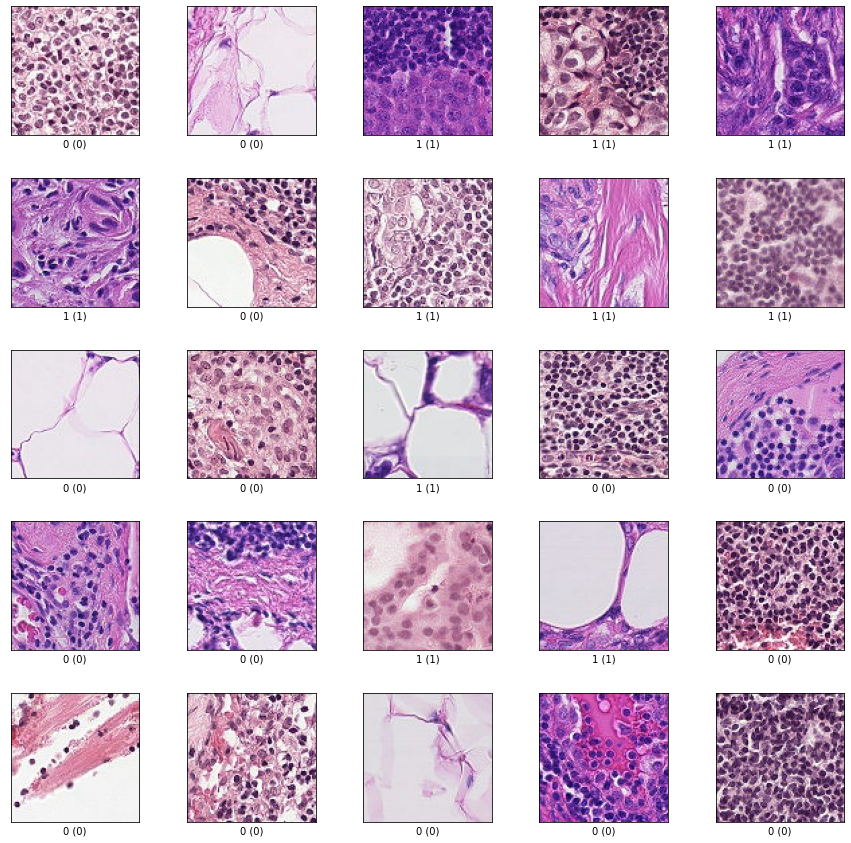

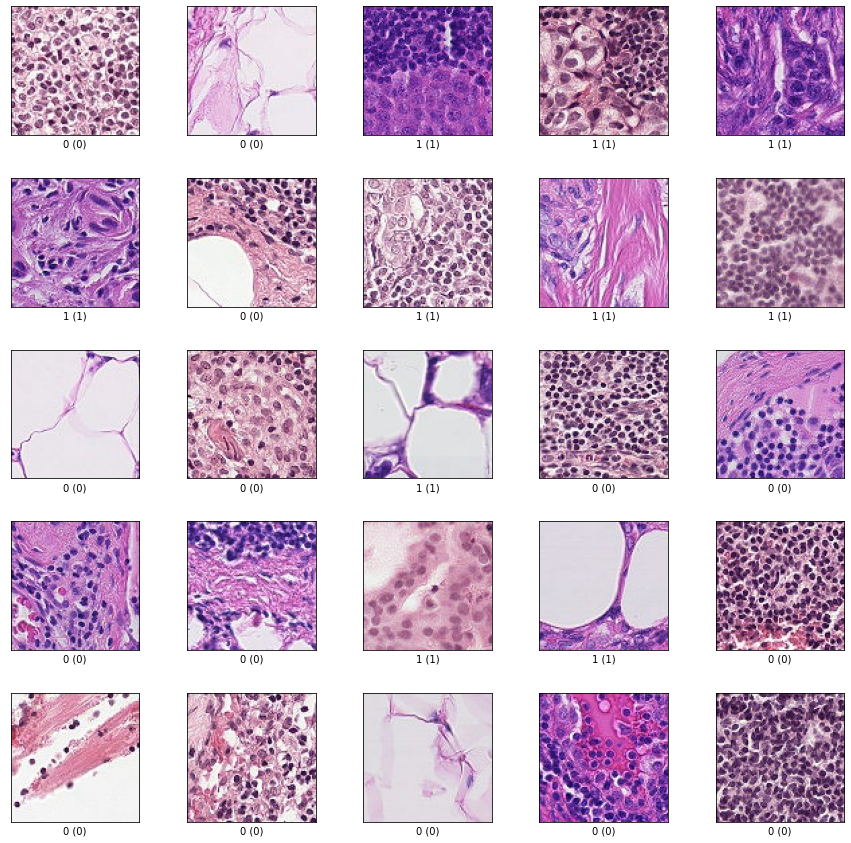

In [ ]:
# First look at examples
tfds.visualization.show_examples(ds=train_ds, ds_info=info, rows=5, cols=5)

## Set up the end-to-end training/evaluation skeleton + get dumb baselines

"At this stage it is best to pick some simple model that you couldn’t possibly have screwed up somehow - e.g. a linear classifier, or a very tiny ConvNet. We’ll want to train it, visualize the losses, any other metrics (e.g. accuracy), model predictions, and perform a series of ablation experiments with explicit hypotheses along the way." - Andrej

### Getting dumb baseline models

Checklist
*   **verify loss @ init** Verify that your loss starts at the correct loss value. E.g. if you initialize your final layer correctly you should measure -log(1/n_classes) on a softmax at initialization. The same default values can be derived for L2 regression, Huber losses, etc
*   **init well** Initialize the final layer weights correctly. E.g. if you are regressing some values that have a mean of 50 then initialize the final bias to 50. If you have an imbalanced dataset of a ratio 1:10 of positives:negatives, set the bias on your logits such that your network predicts probability of 0.1 at initialization. Setting these correctly will speed up convergence and eliminate “hockey stick” loss curves where in the first few iteration your network is basically just learning the bias. -Andrej


In our case, the metastatic/healthy ratio is 0.67, so that should be the initial bias of the final neuron. 







In [ ]:
# Prepare Dataset
BATCH_SIZE = 128
train_ds = train_ds.shuffle(1024)
train_ds = train_ds.map(lambda x,y: (tf.cast(x, dtype='float16'), y))
train_ds = train_ds.map(lambda x,y: (preprocess_input(x), y))
train_ds = train_ds.batch(128)
train_ds = train_ds.repeat()


test_ds = test_ds.map(lambda x,y: (tf.cast(x, dtype='float16'), y))
test_ds = test_ds.map(lambda x,y: (preprocess_input(x), y))
test_ds = test_ds.batch(128)

Defining the Toy Model in TensorFlow

In [ ]:
toy_model = tf.keras.Sequential([
                                 tf.keras.layers.Conv2D(filters=4, 
                                                        kernel_size=(3,3), 
                                                        activation='relu'),
                                 tf.keras.layers.Conv2D(filters=4, 
                                                        kernel_size=(3,3), 
                                                        activation='relu'),
                                 tf.keras.layers.GlobalMaxPooling2D(),
                                 tf.keras.layers.Dense(1, 
                                                       activation='sigmoid', 
                                                       bias_initializer='zeros')])

toy_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])

history = toy_model.fit(train_ds, 
                        validation_data = test_ds, 
                        epochs=50,
                        steps_per_epoch=50)

Epoch 1/50
50/50 [==============================] - 34s 441ms/step - loss: 0.7032 - accuracy: 0.5084 - val_loss: 0.6948 - val_accuracy: 0.5381
Epoch 2/50
50/50 [==============================] - 19s 393ms/step - loss: 0.6879 - accuracy: 0.5481 - val_loss: 0.6781 - val_accuracy: 0.5888
Epoch 3/50
50/50 [==============================] - 19s 390ms/step - loss: 0.6826 - accuracy: 0.5459 - val_loss: 0.6693 - val_accuracy: 0.6202
Epoch 4/50
50/50 [==============================] - 19s 396ms/step - loss: 0.6758 - accuracy: 0.5628 - val_loss: 0.6606 - val_accuracy: 0.6285
Epoch 5/50
50/50 [==============================] - 19s 378ms/step - loss: 0.6699 - accuracy: 0.5953 - val_loss: 0.6510 - val_accuracy: 0.6522
Epoch 6/50
50/50 [==============================] - 19s 397ms/step - loss: 0.6639 - accuracy: 0.6048 - val_loss: 0.6442 - val_accuracy: 0.6609
Epoch 7/50
50/50 [==============================] - 18s 363ms/step - loss: 0.6615 - accuracy: 0.6003 - val_loss: 0.6383 - val_accuracy: 0.6660

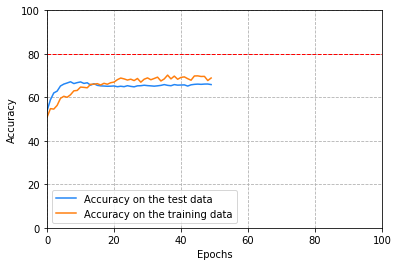

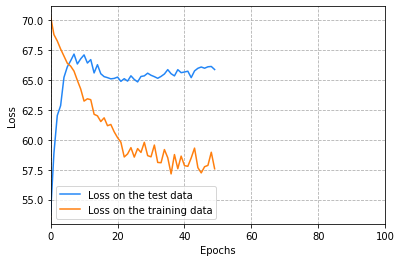

In [ ]:
# Parameters
TRAINING_LENGTH_EPOCHS = 100
MODEL = toy_model
visualize_training(model=toy_model, epochs=TRAINING_LENGTH_EPOCHS)

## 3. Overfit
"The approach I like to take to finding a good model has two stages: first get a model large enough that it can overfit (i.e. focus on training loss) and then regularize it appropriately (give up some training loss to improve the validation loss). The reason I like these two stages is that if we are not able to reach a low error rate with any model at all that may again indicate some issues, bugs, or misconfiguration." - Andrej


Results of experiments:
*   ResNet50V2: train_acc = 92%, test_acc = 82%
*   ResNet152V2: train_acc=94.61%, test_acc=83.3%



In [ ]:
def accuracy_checkpoint():
  return tf.keras.callbacks.ModelCheckpoint(
      filepath="/content/",
      monitor='val_accuracy',
      save_best_only=True
  )

class CamelyonNet(tf.keras.Model):
  def __init__(
      self, 
      use_pooling=True, 
      name="CamelyonNet"):
    super().__init__(name=name)

    # Resnet Base
    self.resnet_base = ResNet152V2(include_top=False, 
                  weights=None,
                  input_shape=(96, 96, 3))
    
    # Pooling and Classification
    self.pooling = None
    if use_pooling:
      self.pooling = tf.keras.layers.GlobalAveragePooling2D()
    else:
      self.pooling = tf.keras.layers.Flatten()
    self.output_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')

  
  def call(self, inputs):
    base_output = self.resnet_base(inputs)
    pooled = self.pooling(base_output)
    output = self.output_layer(pooled)
    return output

"""

base = ResNet152V2(include_top=False, 
                  weights=None,
                  input_shape=(96, 96, 3))
global_pooled = tf.keras.layers.GlobalAveragePooling2D()(base.output)
#hidden_1 = tf.keras.layers.Dense(units=128, activation='relu')(global_pooled)
output = tf.keras.layers.Dense(units=1, activation='sigmoid')(global_pooled)

model = tf.keras.Model(inputs=base.input, outputs=output)
"""
model = CamelyonNet(use_pooling = False)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
model.build(input_shape=(None, 96, 96, 3))
model.summary()

history = model.fit(train_ds, 
                    validation_data = test_ds, 
                    epochs=50,
                    steps_per_epoch=128,
                    callbacks=[accuracy_checkpoint()])


Model: "CamelyonNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 3, 3, 2048)        58331648  
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  18433     
                                                                 
Total params: 58,350,081
Trainable params: 58,206,337
Non-trainable params: 143,744
_________________________________________________________________
Epoch 1/50
128/128 [==============================] - ETA: 0s - loss: 0.6495 - accuracy: 0.7587INFO:tensorflow:Assets written to: /content/assets


INFO:tensorflow:Assets written to: /content/assets


128/128 [==============================] - 149s 1s/step - loss: 0.6495 - accuracy: 0.7587 - val_loss: 1.0562 - val_accuracy: 0.6154
Epoch 2/50
128/128 [==============================] - ETA: 0s - loss: 0.5638 - accuracy: 0.7714INFO:tensorflow:Assets written to: /content/assets


INFO:tensorflow:Assets written to: /content/assets


128/128 [==============================] - 130s 1s/step - loss: 0.5638 - accuracy: 0.7714 - val_loss: 395.8416 - val_accuracy: 0.6504
Epoch 3/50
128/128 [==============================] - 69s 540ms/step - loss: 0.5258 - accuracy: 0.7932 - val_loss: 5225.2554 - val_accuracy: 0.5370
Epoch 4/50
128/128 [==============================] - ETA: 0s - loss: 0.4952 - accuracy: 0.8074INFO:tensorflow:Assets written to: /content/assets


INFO:tensorflow:Assets written to: /content/assets


128/128 [==============================] - 131s 1s/step - loss: 0.4952 - accuracy: 0.8074 - val_loss: 0.8238 - val_accuracy: 0.7826
Epoch 5/50
128/128 [==============================] - 69s 539ms/step - loss: 0.4082 - accuracy: 0.8300 - val_loss: 0.5440 - val_accuracy: 0.7671
Epoch 6/50
128/128 [==============================] - 69s 541ms/step - loss: 0.3877 - accuracy: 0.8367 - val_loss: 0.4867 - val_accuracy: 0.7792
Epoch 7/50
128/128 [==============================] - 69s 540ms/step - loss: 0.3790 - accuracy: 0.8399 - val_loss: 0.5484 - val_accuracy: 0.7241
Epoch 8/50
128/128 [==============================] - 69s 540ms/step - loss: 0.4334 - accuracy: 0.8320 - val_loss: 1.6135 - val_accuracy: 0.4603
Epoch 9/50
128/128 [==============================] - 69s 540ms/step - loss: 0.5063 - accuracy: 0.7908 - val_loss: 0.6912 - val_accuracy: 0.7267
Epoch 10/50
128/128 [==============================] - ETA: 0s - loss: 0.3960 - accuracy: 0.8333INFO:tensorflow:Assets written to: /content/ass

INFO:tensorflow:Assets written to: /content/assets


128/128 [==============================] - 131s 1s/step - loss: 0.3960 - accuracy: 0.8333 - val_loss: 0.4575 - val_accuracy: 0.8019
Epoch 11/50
128/128 [==============================] - 69s 539ms/step - loss: 0.3602 - accuracy: 0.8481 - val_loss: 0.4486 - val_accuracy: 0.7822
Epoch 12/50
128/128 [==============================] - 69s 539ms/step - loss: 0.5522 - accuracy: 0.7857 - val_loss: 0.7354 - val_accuracy: 0.5146
Epoch 13/50
128/128 [==============================] - 69s 540ms/step - loss: 0.4999 - accuracy: 0.7968 - val_loss: 74.5792 - val_accuracy: 0.6840
Epoch 14/50
128/128 [==============================] - ETA: 0s - loss: 0.4192 - accuracy: 0.8199INFO:tensorflow:Assets written to: /content/assets


INFO:tensorflow:Assets written to: /content/assets


128/128 [==============================] - 130s 1s/step - loss: 0.4192 - accuracy: 0.8199 - val_loss: 1.4890 - val_accuracy: 0.8026
Epoch 15/50
128/128 [==============================] - 69s 539ms/step - loss: 0.4079 - accuracy: 0.8299 - val_loss: 0.5961 - val_accuracy: 0.7561
Epoch 16/50
128/128 [==============================] - 69s 539ms/step - loss: 0.4415 - accuracy: 0.8215 - val_loss: 0.6029 - val_accuracy: 0.7491
Epoch 17/50
128/128 [==============================] - 70s 543ms/step - loss: 0.4078 - accuracy: 0.8250 - val_loss: 0.5792 - val_accuracy: 0.8008
Epoch 18/50
128/128 [==============================] - 69s 539ms/step - loss: 0.3714 - accuracy: 0.8397 - val_loss: 1.9611 - val_accuracy: 0.7823
Epoch 19/50
128/128 [==============================] - 69s 539ms/step - loss: 0.3519 - accuracy: 0.8516 - val_loss: 1.0577 - val_accuracy: 0.7400
Epoch 20/50
128/128 [==============================] - 69s 541ms/step - loss: 0.3432 - accuracy: 0.8552 - val_loss: 0.7303 - val_accuracy:

INFO:tensorflow:Assets written to: /content/assets


128/128 [==============================] - 131s 1s/step - loss: 0.2974 - accuracy: 0.8811 - val_loss: 0.4686 - val_accuracy: 0.8154
Epoch 31/50
128/128 [==============================] - 69s 538ms/step - loss: 0.2828 - accuracy: 0.8843 - val_loss: 0.5922 - val_accuracy: 0.7794
Epoch 32/50
128/128 [==============================] - ETA: 0s - loss: 0.2937 - accuracy: 0.8780INFO:tensorflow:Assets written to: /content/assets


INFO:tensorflow:Assets written to: /content/assets


128/128 [==============================] - 132s 1s/step - loss: 0.2937 - accuracy: 0.8780 - val_loss: 0.4231 - val_accuracy: 0.8233
Epoch 33/50
128/128 [==============================] - 71s 541ms/step - loss: 0.3120 - accuracy: 0.8746 - val_loss: 0.4350 - val_accuracy: 0.8107
Epoch 34/50
128/128 [==============================] - 69s 539ms/step - loss: 0.4723 - accuracy: 0.8107 - val_loss: 4.7003 - val_accuracy: 0.5037
Epoch 35/50
128/128 [==============================] - 69s 539ms/step - loss: 0.3468 - accuracy: 0.8547 - val_loss: 1.2587 - val_accuracy: 0.6417
Epoch 36/50
128/128 [==============================] - 69s 540ms/step - loss: 0.3302 - accuracy: 0.8613 - val_loss: 0.4564 - val_accuracy: 0.7698
Epoch 37/50
128/128 [==============================] - ETA: 0s - loss: 0.3183 - accuracy: 0.8677INFO:tensorflow:Assets written to: /content/assets


INFO:tensorflow:Assets written to: /content/assets


128/128 [==============================] - 131s 1s/step - loss: 0.3183 - accuracy: 0.8677 - val_loss: 0.3836 - val_accuracy: 0.8304
Epoch 38/50
128/128 [==============================] - 69s 543ms/step - loss: 0.3029 - accuracy: 0.8763 - val_loss: 0.4387 - val_accuracy: 0.7909
Epoch 39/50
128/128 [==============================] - 69s 540ms/step - loss: 0.3022 - accuracy: 0.8788 - val_loss: 0.4798 - val_accuracy: 0.7759
Epoch 40/50
128/128 [==============================] - 69s 541ms/step - loss: 0.2876 - accuracy: 0.8840 - val_loss: 0.5734 - val_accuracy: 0.7725
Epoch 41/50
128/128 [==============================] - 69s 538ms/step - loss: 0.2781 - accuracy: 0.8881 - val_loss: 0.5187 - val_accuracy: 0.7777
Epoch 42/50
128/128 [==============================] - 69s 538ms/step - loss: 0.2733 - accuracy: 0.8888 - val_loss: 5.5597 - val_accuracy: 0.7926
Epoch 43/50
128/128 [==============================] - 69s 539ms/step - loss: 0.2770 - accuracy: 0.8865 - val_loss: 33.4355 - val_accuracy

INFO:tensorflow:Assets written to: /content/assets


128/128 [==============================] - 132s 1s/step - loss: 0.2609 - accuracy: 0.8958 - val_loss: 1.2981 - val_accuracy: 0.8314
Epoch 48/50
128/128 [==============================] - 69s 541ms/step - loss: 0.2711 - accuracy: 0.8882 - val_loss: 483.7748 - val_accuracy: 0.5599
Epoch 49/50
128/128 [==============================] - 70s 544ms/step - loss: 0.2806 - accuracy: 0.8870 - val_loss: 0.5159 - val_accuracy: 0.7859
Epoch 50/50
128/128 [==============================] - 69s 542ms/step - loss: 0.2567 - accuracy: 0.8994 - val_loss: 0.6035 - val_accuracy: 0.7623


In [ ]:
# Parameters
visualize_training(model, epochs=50)

## 4. Regularize
"We are now at a place where we have a large model that is fitting at least the training set. Now it is time to regularize it and gain some validation accuracy by giving up some of the training accuracy. Some tips & tricks:

*    **get more data**. First, the by far best and preferred way to regularize a model in any practical setting is to add more real training data. It is a very common mistake to spend a lot engineering cycles trying to squeeze juice out of a small dataset when you could instead be collecting more data. As far as I’m aware adding more data is pretty much the only guaranteed way to monotonically improve the performance of a well-configured neural network almost indefinitely. The other would be ensembles (if you can afford them), but that tops out after ~5 models.
*    **data augment.** The next best thing to real data is half-fake data - try out more aggressive data augmentation.
creative augmentation. If half-fake data doesn’t do it, fake data may also do something. People are finding creative ways of expanding datasets; For example, domain randomization, use of simulation, clever hybrids such as inserting (potentially simulated) data into scenes, or even GANs.
*    **pretrain.** It rarely ever hurts to use a pretrained network if you can, even if you have enough data.
*   **stick with supervised learning.** Do not get over-excited about unsupervised pretraining. Unlike what that blog post from 2008 tells you, as far as I know, no version of it has reported strong results in modern computer vision (though NLP seems to be doing pretty well with BERT and friends these days, quite likely owing to the more deliberate nature of text, and a higher signal to noise ratio).
*   **smaller input dimensionality.** Remove features that may contain spurious signal. Any added spurious input is just another opportunity to overfit if your dataset is small. Similarly, if low-level details don’t matter much try to input a smaller image.
*   **smaller model size.** In many cases you can use domain knowledge constraints on the network to decrease its size. As an example, it used to be trendy to use Fully Connected layers at the top of backbones for ImageNet but these have since been replaced with simple average pooling, eliminating a ton of parameters in the process.
*   **decrease the batch size.** Due to the normalization inside batch norm smaller batch sizes somewhat correspond to stronger regularization. This is because the batch empirical mean/std are more approximate versions of the full mean/std so the scale & offset “wiggles” your batch around more.
drop. Add dropout. Use dropout2d (spatial dropout) for ConvNets. Use this sparingly/carefully because dropout does not seem to play nice with batch normalization.
*   **weight decay.** Increase the weight decay penalty.
early stopping. Stop training based on your measured validation loss to catch your model just as it’s about to overfit. try a larger model. I mention this last and only after early stopping but I’ve found a few times in the past that larger models will of course overfit much more eventually, but their “early stopped” performance can often be much better than that of smaller models.




The experiments I have in mind for this bit is as follows:

*   Pretrain with contrastive loss as described in SimCLR
*   

